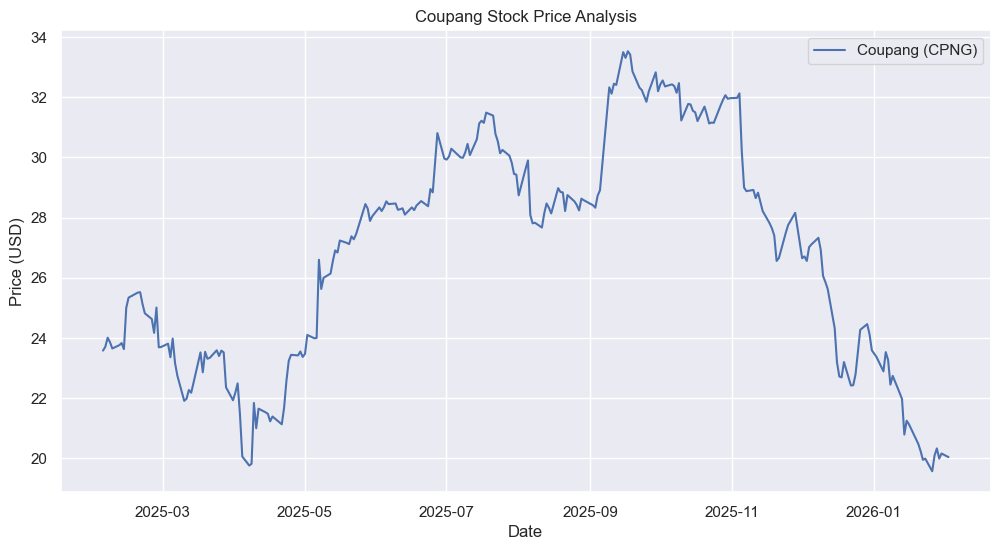

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. 데이터 불러오기
# (방금 만든 상대 경로 로직을 활용하거나, 파일명을 직접 지정)
file_path = 'stock_db/CPNG.csv' 

if os.path.exists(file_path):
    df = pd.read_csv(file_path)

    # 2. 날짜 컬럼을 진짜 '날짜 형식'으로 변환
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    df.set_index('Date', inplace=True)

    # 3. 그래프 스타일 설정
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(12, 6))

    # 4. 수정 종가(Adj Close) 그리기
    sns.lineplot(data=df, x=df.index, y='Close', label='Coupang (CPNG)')

    plt.title('Coupang Stock Price Analysis')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()
    
else:
    print("파일이 없습니다. 경로를 확인해주세요!")

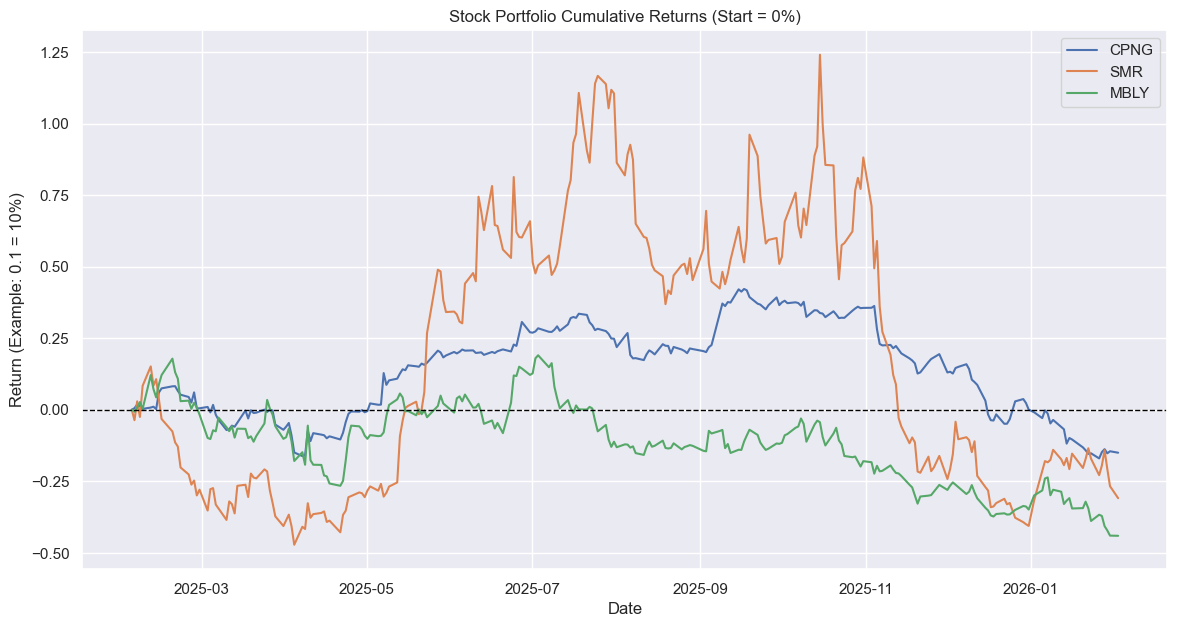

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. 종목 리스트 정의
tickers = ['CPNG', 'SMR', 'MBLY']
plt.figure(figsize=(14, 7))

# 2. 반복문으로 데이터 하나씩 꺼내오기
for ticker in tickers:
    file_path = f'stock_db/{ticker}.csv'
    
    if os.path.exists(file_path):
        # 데이터 읽기
        df = pd.read_csv(file_path)
        
        # 날짜 변환 (UTC 필수!)
        df['Date'] = pd.to_datetime(df['Date'], utc=True)
        df.set_index('Date', inplace=True)
        
        # [핵심 로직] 누적 수익률 계산 (Cumulative Return)
        # 공식: (현재가격 / 첫날가격) - 1
        # iloc[0]은 첫 번째 행(시작일)의 가격
        first_price = df['Close'].iloc[0]
        df['Return'] = (df['Close'] / first_price) - 1
        
        # 그래프 그리기 (수익률 기준)
        sns.lineplot(data=df, x=df.index, y='Return', label=f'{ticker}')

# 3. 그래프 꾸미기
plt.title('Stock Portfolio Cumulative Returns (Start = 0%)')
plt.xlabel('Date')
plt.ylabel('Return (Example: 0.1 = 10%)')
plt.axhline(0, color='black', linestyle='--', linewidth=1) # 0% 기준선
plt.legend()
plt.show()

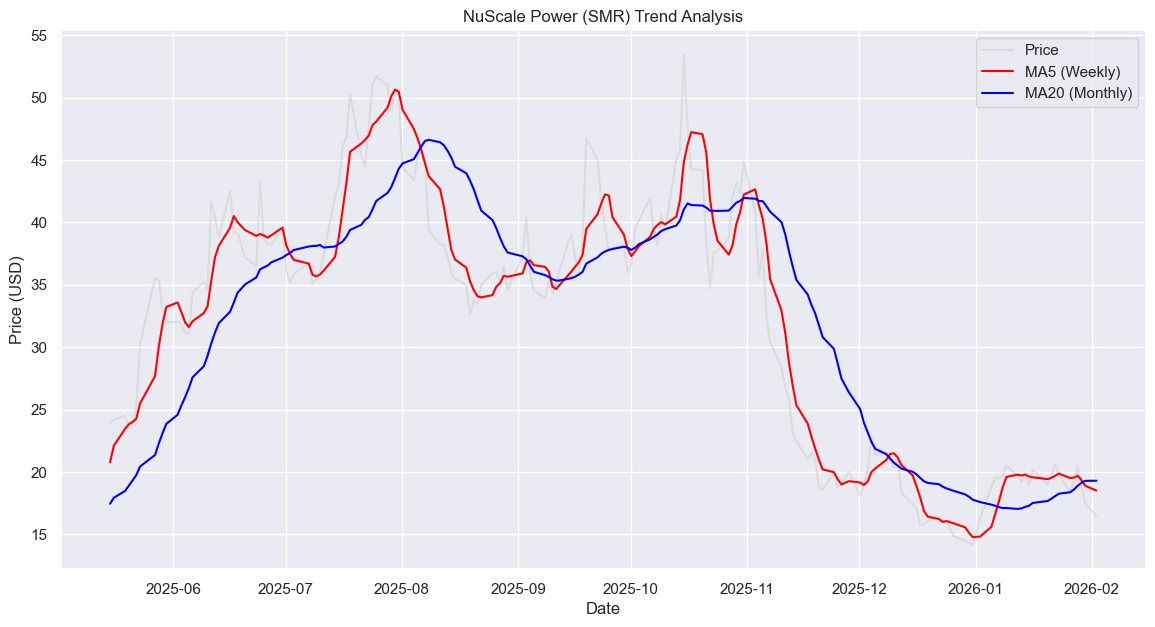

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. 가장 핫한 SMR(뉴스케일)만 집중 분석
file_path = 'stock_db/SMR.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    
    # 날짜 변환 및 정렬
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True) # 날짜 순서대로 정렬 (중요!)

    # [핵심 로직] 이동평균선(MA) 계산
    # rolling(window=5): 5일치 창문을 밀면서 평균을 냄
    df['MA5'] = df['Close'].rolling(window=5).mean()   # 1주일 추세
    df['MA20'] = df['Close'].rolling(window=20).mean() # 1개월 추세

    # 2. 그래프 그리기 (최근 6개월만 확대해서 보기)
    # 데이터가 너무 길면 잘 안보이니, 최근 데이터만 슬라이싱 합니다.
    subset = df.tail(180) 

    plt.figure(figsize=(14, 7))
    
    # 실제 가격 (회색 얇은 선)
    sns.lineplot(data=subset, x=subset.index, y='Close', label='Price', color='lightgray', alpha=0.6)
    
    # 5일선 (빨간색 - 기민하게 움직임)
    sns.lineplot(data=subset, x=subset.index, y='MA5', label='MA5 (Weekly)', color='red', linewidth=1.5)
    
    # 20일선 (파란색 - 묵직하게 움직임)
    sns.lineplot(data=subset, x=subset.index, y='MA20', label='MA20 (Monthly)', color='blue', linewidth=1.5)

    plt.title('NuScale Power (SMR) Trend Analysis')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

else:
    print("데이터 파일이 없습니다.")

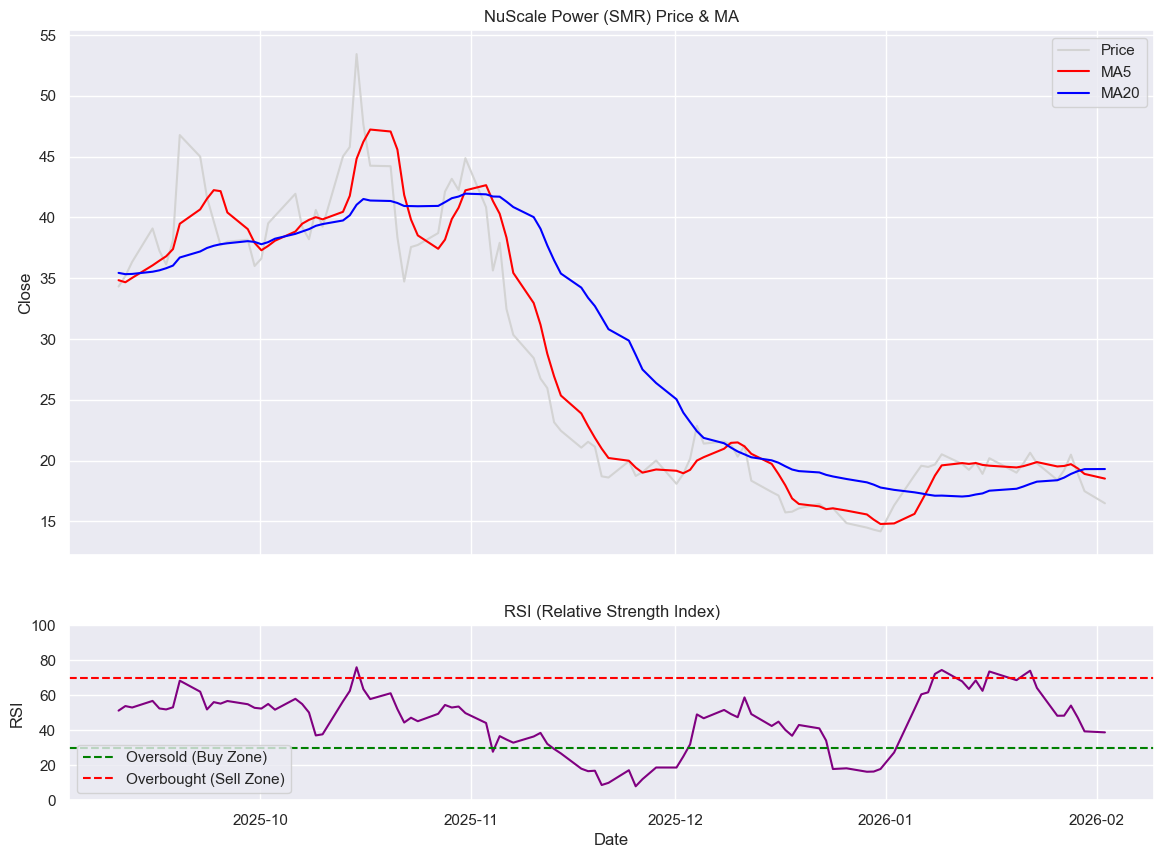

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# 1. 데이터 불러오기
file_path = 'stock_db/SMR.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

    # 2. 이동평균선 계산
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()

    # [NEW] 3. RSI(상대강도지수) 계산 로직
    # 공식: 100 - (100 / (1 + RS))
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # --- 시각화 (위: 주가 / 아래: RSI) ---
    subset = df.tail(100) # 최근 100일만 보기

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # 위쪽 그래프 (주가 + 이평선)
    sns.lineplot(data=subset, x=subset.index, y='Close', label='Price', color='lightgray', ax=ax1)
    sns.lineplot(data=subset, x=subset.index, y='MA5', label='MA5', color='red', ax=ax1)
    sns.lineplot(data=subset, x=subset.index, y='MA20', label='MA20', color='blue', ax=ax1)
    ax1.set_title('NuScale Power (SMR) Price & MA')
    ax1.legend()

    # 아래쪽 그래프 (RSI)
    sns.lineplot(data=subset, x=subset.index, y='RSI', color='purple', ax=ax2)
    ax2.axhline(30, color='green', linestyle='--', label='Oversold (Buy Zone)') # 30선
    ax2.axhline(70, color='red', linestyle='--', label='Overbought (Sell Zone)') # 70선
    ax2.set_title('RSI (Relative Strength Index)')
    ax2.set_ylim(0, 100) # 0~100 범위 고정
    ax2.legend()

    plt.show()

else:
    print("데이터 파일이 없습니다.")

In [8]:
import pandas as pd
import numpy as np
import os

# 분석할 종목들
tickers = ['CPNG', 'SMR', 'MBLY']

print(f"{'종목':<6} | {'현재가':<8} | {'5일평균':<8} | {'RSI':<6} | {'추천 행동 (Action)':<10}")
print("-" * 60)

for ticker in tickers:
    file_path = f'stock_db/{ticker}.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'], utc=True)
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)

        # 1. 이동평균선(MA5) 계산
        df['MA5'] = df['Close'].rolling(window=5).mean()

        # 2. RSI 계산
        delta = df['Close'].diff(1)
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # 3. 가장 최근 데이터(오늘/어제) 가져오기
        today = df.iloc[-1]
        price = today['Close']
        ma5 = today['MA5']
        rsi = today['RSI']

        # 4. 퀀트 알고리즘 (매수 로직)
        action = "WAIT ✋" # 기본값은 대기
        
        # 조건 1: RSI가 40 이하고 (저평가)
        # 조건 2: 현재가가 5일선 위에 있을 때 (추세 전환)
        if rsi < 40 and price > ma5:
            action = "BUY 🚀 (진입 기회!)"
        elif rsi < 30:
            action = "WATCH 👀 (반등 감시)"
        elif rsi > 70:
            action = "SELL 💰 (과열)"

        # 결과 출력
        print(f"{ticker:<6} | {price:<8.2f} | {ma5:<8.2f} | {rsi:<6.1f} | {action}")

종목     | 현재가      | 5일평균     | RSI    | 추천 행동 (Action)
------------------------------------------------------------
CPNG   | 20.04    | 20.12    | 28.7   | WATCH 👀 (반등 감시)
SMR    | 16.48    | 18.51    | 38.8   | WAIT ✋
MBLY   | 8.97     | 9.36     | 23.1   | WATCH 👀 (반등 감시)


c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48260 (\N{HANGUL SYLLABLE BEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47029 (\N{HANGUL SYLLABLE RYAG}) missing from font(s

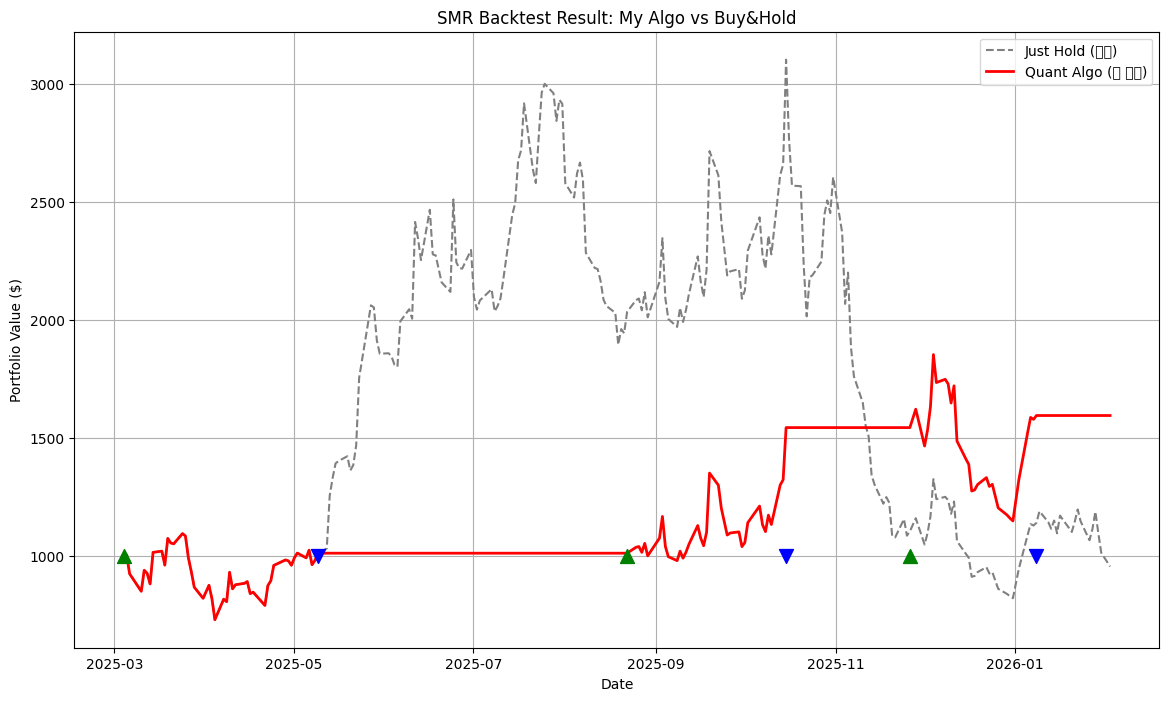

💰 초기 자본: $1000.00
🤖 퀀트 전략 최종: $1595.40 (수익률: 59.54%)
🗿 존버 전략 최종: $956.47 (수익률: -4.35%)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. 데이터 준비 (SMR)
file_path = 'stock_db/SMR.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

    # 2. 보조지표 계산 (RSI, MA5)
    df['MA5'] = df['Close'].rolling(window=5).mean()
    
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # 3. 백테스팅 루프 (Time Machine Loop)
    capital = 1000.0 # 초기 자본 $1,000
    shares = 0       # 보유 주식 수
    position = False # 현재 주식을 가지고 있나요?
    
    buy_signals = []  # 매수 기록용
    sell_signals = [] # 매도 기록용
    portfolio_value = [] # 내 계좌 가치 변화

    # 데이터의 절반 이후부터 시작 (지표 계산 기간 확보)
    start_idx = 20 
    
    for i in range(start_idx, len(df)):
        today = df.iloc[i]
        price = today['Close']
        rsi = today['RSI']
        ma5 = today['MA5']
        date = df.index[i]

        # [매수 로직] 주식이 없고, 조건(RSI<40 & 상승추세)이 맞으면?
        if not position and rsi < 40 and price > ma5:
            shares = capital / price # 전액 매수
            capital = 0
            position = True
            buy_signals.append((date, price))
            # print(f"BUY!  {date.date()} @ ${price:.2f}")

        # [매도 로직] 주식이 있고, RSI가 70 넘으면?
        elif position and rsi > 70:
            capital = shares * price # 전액 매도
            shares = 0
            position = False
            sell_signals.append((date, price))
            # print(f"SELL! {date.date()} @ ${price:.2f}")

        # 매일매일 내 재산 가치 기록
        current_value = capital + (shares * price)
        portfolio_value.append(current_value)

    # 4. 결과 시각화
    # 데이터 길이를 맞춤
    result_df = df.iloc[start_idx:].copy()
    result_df['My_Portfolio'] = portfolio_value
    
    # Buy & Hold (그냥 들고 있었을 때) 수익률 계산
    initial_price = result_df['Close'].iloc[0]
    result_df['Buy_Hold'] = (result_df['Close'] / initial_price) * 1000

    plt.figure(figsize=(14, 8))
    
    # 수익률 곡선 비교
    plt.plot(result_df.index, result_df['Buy_Hold'], label='Just Hold (존버)', color='gray', linestyle='--')
    plt.plot(result_df.index, result_df['My_Portfolio'], label='Quant Algo (내 전략)', color='red', linewidth=2)

    # 매매 시점 표시
    for date, price in buy_signals:
        plt.scatter(date, 1000, marker='^', color='green', s=100, zorder=5) # 1000은 그냥 표시 위치
    for date, price in sell_signals:
        plt.scatter(date, 1000, marker='v', color='blue', s=100, zorder=5)

    plt.title(f"SMR Backtest Result: My Algo vs Buy&Hold")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5. 최종 성적표 출력
    final_val = portfolio_value[-1]
    bh_val = result_df['Buy_Hold'].iloc[-1]
    
    print(f"💰 초기 자본: $1000.00")
    print(f"🤖 퀀트 전략 최종: ${final_val:.2f} (수익률: {((final_val/1000)-1)*100:.2f}%)")
    print(f"🗿 존버 전략 최종: ${bh_val:.2f} (수익률: {((bh_val/1000)-1)*100:.2f}%)")
    
else:
    print("SMR 데이터가 없습니다.")

c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48260 (\N{HANGUL SYLLABLE BEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47029 (\N{HANGUL SYLLABLE RYAG}) missing from font(s

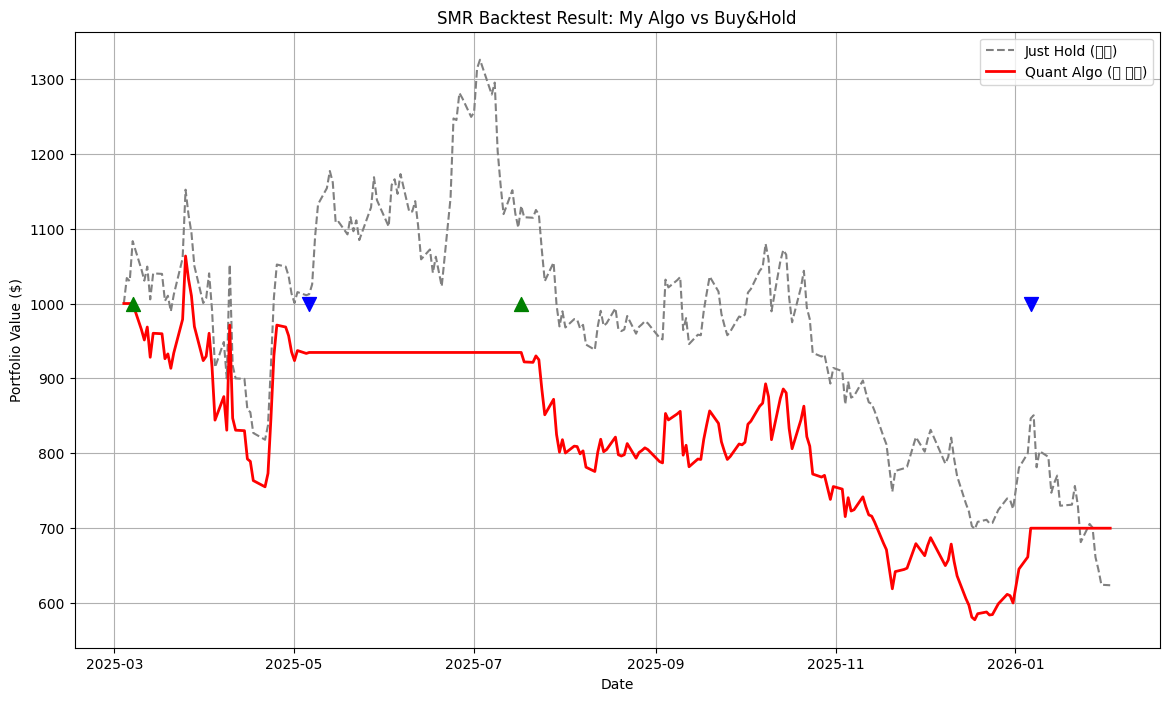

💰 초기 자본: $1000.00
🤖 퀀트 전략 최종: $699.64 (수익률: -30.04%)
🗿 존버 전략 최종: $623.35 (수익률: -37.67%)


In [2]:
# 1. 데이터 준비 (SMR)
file_path = 'stock_db/MBLY.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

    # 2. 보조지표 계산 (RSI, MA5)
    df['MA5'] = df['Close'].rolling(window=5).mean()
    
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # 3. 백테스팅 루프 (Time Machine Loop)
    capital = 1000.0 # 초기 자본 $1,000
    shares = 0       # 보유 주식 수
    position = False # 현재 주식을 가지고 있나요?
    
    buy_signals = []  # 매수 기록용
    sell_signals = [] # 매도 기록용
    portfolio_value = [] # 내 계좌 가치 변화

    # 데이터의 절반 이후부터 시작 (지표 계산 기간 확보)
    start_idx = 20 
    
    for i in range(start_idx, len(df)):
        today = df.iloc[i]
        price = today['Close']
        rsi = today['RSI']
        ma5 = today['MA5']
        date = df.index[i]

        # [매수 로직] 주식이 없고, 조건(RSI<40 & 상승추세)이 맞으면?
        if not position and rsi < 40 and price > ma5:
            shares = capital / price # 전액 매수
            capital = 0
            position = True
            buy_signals.append((date, price))
            # print(f"BUY!  {date.date()} @ ${price:.2f}")

        # [매도 로직] 주식이 있고, RSI가 70 넘으면?
        elif position and rsi > 70:
            capital = shares * price # 전액 매도
            shares = 0
            position = False
            sell_signals.append((date, price))
            # print(f"SELL! {date.date()} @ ${price:.2f}")

        # 매일매일 내 재산 가치 기록
        current_value = capital + (shares * price)
        portfolio_value.append(current_value)

    # 4. 결과 시각화
    # 데이터 길이를 맞춤
    result_df = df.iloc[start_idx:].copy()
    result_df['My_Portfolio'] = portfolio_value
    
    # Buy & Hold (그냥 들고 있었을 때) 수익률 계산
    initial_price = result_df['Close'].iloc[0]
    result_df['Buy_Hold'] = (result_df['Close'] / initial_price) * 1000

    plt.figure(figsize=(14, 8))
    
    # 수익률 곡선 비교
    plt.plot(result_df.index, result_df['Buy_Hold'], label='Just Hold (존버)', color='gray', linestyle='--')
    plt.plot(result_df.index, result_df['My_Portfolio'], label='Quant Algo (내 전략)', color='red', linewidth=2)

    # 매매 시점 표시
    for date, price in buy_signals:
        plt.scatter(date, 1000, marker='^', color='green', s=100, zorder=5) # 1000은 그냥 표시 위치
    for date, price in sell_signals:
        plt.scatter(date, 1000, marker='v', color='blue', s=100, zorder=5)

    plt.title(f"SMR Backtest Result: My Algo vs Buy&Hold")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5. 최종 성적표 출력
    final_val = portfolio_value[-1]
    bh_val = result_df['Buy_Hold'].iloc[-1]
    
    print(f"💰 초기 자본: $1000.00")
    print(f"🤖 퀀트 전략 최종: ${final_val:.2f} (수익률: {((final_val/1000)-1)*100:.2f}%)")
    print(f"🗿 존버 전략 최종: ${bh_val:.2f} (수익률: {((bh_val/1000)-1)*100:.2f}%)")
    
else:
    print("SMR 데이터가 없습니다.")

c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48260 (\N{HANGUL SYLLABLE BEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47029 (\N{HANGUL SYLLABLE RYAG}) missing from font(s

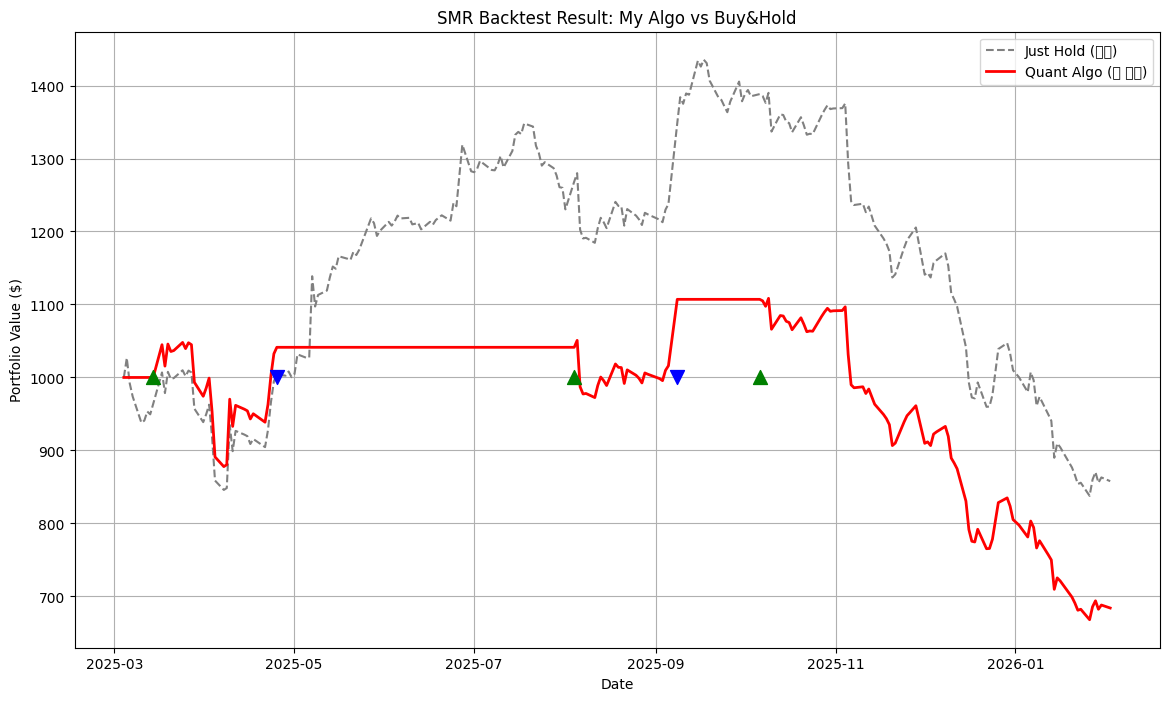

💰 초기 자본: $1000.00
🤖 퀀트 전략 최종: $684.09 (수익률: -31.59%)
🗿 존버 전략 최종: $857.88 (수익률: -14.21%)


In [3]:
# 1. 데이터 준비 (SMR)
file_path = 'stock_db/CPNG.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

    # 2. 보조지표 계산 (RSI, MA5)
    df['MA5'] = df['Close'].rolling(window=5).mean()
    
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # 3. 백테스팅 루프 (Time Machine Loop)
    capital = 1000.0 # 초기 자본 $1,000
    shares = 0       # 보유 주식 수
    position = False # 현재 주식을 가지고 있나요?
    
    buy_signals = []  # 매수 기록용
    sell_signals = [] # 매도 기록용
    portfolio_value = [] # 내 계좌 가치 변화

    # 데이터의 절반 이후부터 시작 (지표 계산 기간 확보)
    start_idx = 20 
    
    for i in range(start_idx, len(df)):
        today = df.iloc[i]
        price = today['Close']
        rsi = today['RSI']
        ma5 = today['MA5']
        date = df.index[i]

        # [매수 로직] 주식이 없고, 조건(RSI<40 & 상승추세)이 맞으면?
        if not position and rsi < 40 and price > ma5:
            shares = capital / price # 전액 매수
            capital = 0
            position = True
            buy_signals.append((date, price))
            # print(f"BUY!  {date.date()} @ ${price:.2f}")

        # [매도 로직] 주식이 있고, RSI가 70 넘으면?
        elif position and rsi > 70:
            capital = shares * price # 전액 매도
            shares = 0
            position = False
            sell_signals.append((date, price))
            # print(f"SELL! {date.date()} @ ${price:.2f}")

        # 매일매일 내 재산 가치 기록
        current_value = capital + (shares * price)
        portfolio_value.append(current_value)

    # 4. 결과 시각화
    # 데이터 길이를 맞춤
    result_df = df.iloc[start_idx:].copy()
    result_df['My_Portfolio'] = portfolio_value
    
    # Buy & Hold (그냥 들고 있었을 때) 수익률 계산
    initial_price = result_df['Close'].iloc[0]
    result_df['Buy_Hold'] = (result_df['Close'] / initial_price) * 1000

    plt.figure(figsize=(14, 8))
    
    # 수익률 곡선 비교
    plt.plot(result_df.index, result_df['Buy_Hold'], label='Just Hold (존버)', color='gray', linestyle='--')
    plt.plot(result_df.index, result_df['My_Portfolio'], label='Quant Algo (내 전략)', color='red', linewidth=2)

    # 매매 시점 표시
    for date, price in buy_signals:
        plt.scatter(date, 1000, marker='^', color='green', s=100, zorder=5) # 1000은 그냥 표시 위치
    for date, price in sell_signals:
        plt.scatter(date, 1000, marker='v', color='blue', s=100, zorder=5)

    plt.title(f"SMR Backtest Result: My Algo vs Buy&Hold")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5. 최종 성적표 출력
    final_val = portfolio_value[-1]
    bh_val = result_df['Buy_Hold'].iloc[-1]
    
    print(f"💰 초기 자본: $1000.00")
    print(f"🤖 퀀트 전략 최종: ${final_val:.2f} (수익률: {((final_val/1000)-1)*100:.2f}%)")
    print(f"🗿 존버 전략 최종: ${bh_val:.2f} (수익률: {((bh_val/1000)-1)*100:.2f}%)")
    
else:
    print("SMR 데이터가 없습니다.")

🚀 BUY at 2025-03-21 : $23.34
📉 SELL at 2025-04-01 : $22.18
🚀 BUY at 2025-04-24 : $23.24
📉 SELL at 2025-07-28 : $30.06
🚀 BUY at 2025-08-28 : $28.63
📉 SELL at 2025-08-29 : $28.58
🚀 BUY at 2025-09-02 : $28.41
📉 SELL at 2025-10-03 : $32.36
🚀 BUY at 2025-10-30 : $31.95
📉 SELL at 2025-11-06 : $29.00


c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48260 (\N{HANGUL SYLLABLE BEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44264 (\N{HANGUL SYLLABLE GOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46304 (\N{HANGUL SYLLABLE DEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaeo\quant_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s)

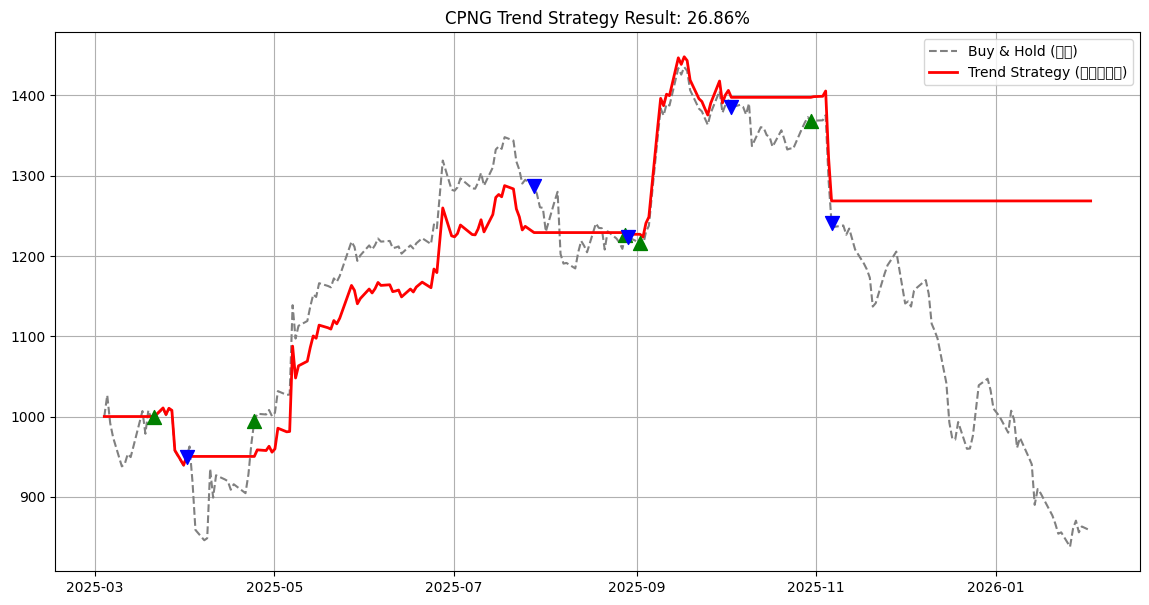

💰 최종 수익률: 26.86%


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. 쿠팡(CPNG) 집중 공략
ticker = 'CPNG'
file_path = f'stock_db/{ticker}.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

    # 2. 이동평균선 계산 (5일선, 20일선)
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()

    # 3. 백테스팅 (골든크로스 전략)
    capital = 1000.0
    shares = 0
    position = False
    
    buy_signals = []
    sell_signals = []
    portfolio_value = []
    
    # MA20이 계산되는 시점부터 시작
    start_idx = 20
    
    for i in range(start_idx, len(df)):
        today = df.iloc[i]
        yesterday = df.iloc[i-1] # 어제 데이터 (크로스 확인용)
        
        price = today['Close']
        date = df.index[i]
        
        # [매수 조건] 어제는 5일선이 20일선 아래였는데, 오늘 위로 뚫었을 때 (Golden Cross)
        golden_cross = (yesterday['MA5'] < yesterday['MA20']) and (today['MA5'] > today['MA20'])
        
        # [매도 조건] 어제는 위에 있었는데, 오늘 아래로 뚫었을 때 (Dead Cross)
        dead_cross = (yesterday['MA5'] > yesterday['MA20']) and (today['MA5'] < today['MA20'])

        if not position and golden_cross:
            shares = capital / price
            capital = 0
            position = True
            buy_signals.append((date, price))
            print(f"🚀 BUY at {date.date()} : ${price:.2f}")

        elif position and dead_cross:
            capital = shares * price
            shares = 0
            position = False
            sell_signals.append((date, price))
            print(f"📉 SELL at {date.date()} : ${price:.2f}")
            
        # 자산 가치 기록
        current_val = capital + (shares * price)
        portfolio_value.append(current_val)

    # 4. 결과 시각화
    plt.figure(figsize=(14, 7))
    
    # 벤치마크 (Buy & Hold)
    initial_price = df['Close'].iloc[start_idx]
    buy_hold = (df['Close'].iloc[start_idx:] / initial_price) * 1000
    
    # 그래프 그리기
    plt.plot(df.index[start_idx:], buy_hold, label='Buy & Hold (존버)', color='gray', linestyle='--')
    plt.plot(df.index[start_idx:], portfolio_value, label='Trend Strategy (골든크로스)', color='red', linewidth=2)

    # 매매 타점 표시
    for date, price in buy_signals:
        plt.scatter(date, price * (1000/initial_price), marker='^', color='green', s=100, zorder=5)
    for date, price in sell_signals:
        plt.scatter(date, price * (1000/initial_price), marker='v', color='blue', s=100, zorder=5)

    final_return = ((portfolio_value[-1] / 1000) - 1) * 100
    plt.title(f"CPNG Trend Strategy Result: {final_return:.2f}%")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"💰 최종 수익률: {final_return:.2f}%")

else:
    print("데이터 파일이 없습니다.")

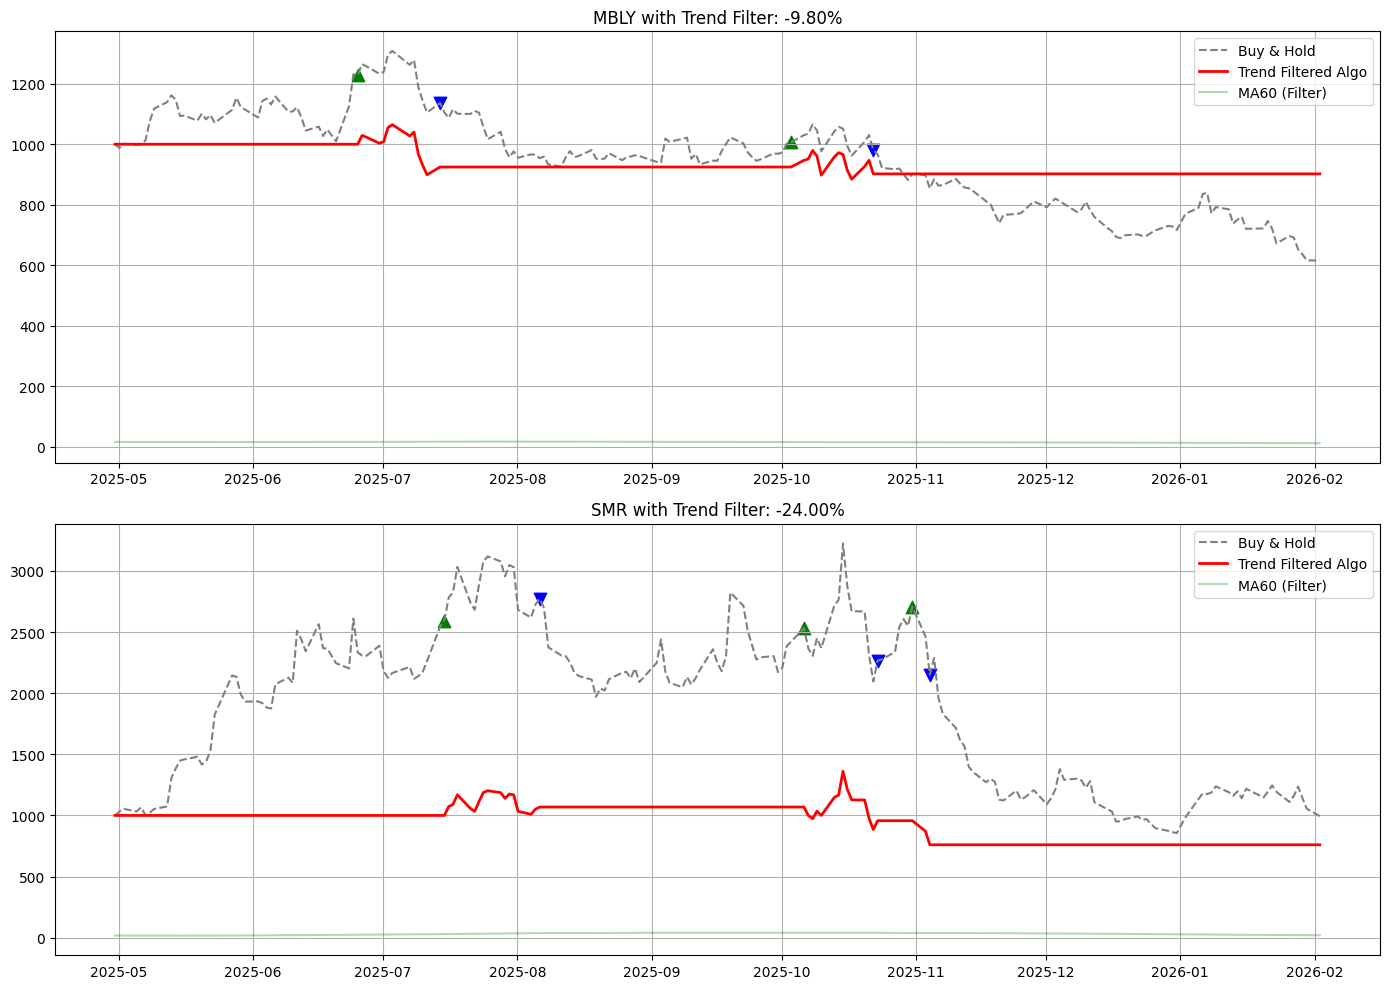

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 손실이 컸던 두 종목 테스트
tickers = ['MBLY', 'SMR'] 

plt.figure(figsize=(14, 10))

for idx, ticker in enumerate(tickers):
    file_path = f'stock_db/{ticker}.csv'
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'], utc=True)
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)

        # 1. 이동평균선 계산 (5일, 20일, 60일)
        df['MA5'] = df['Close'].rolling(window=5).mean()
        df['MA20'] = df['Close'].rolling(window=20).mean()
        df['MA60'] = df['Close'].rolling(window=60).mean() # 장기 추세선

        # 2. 백테스팅
        capital = 1000.0
        shares = 0
        position = False
        
        buy_signals = []
        sell_signals = []
        portfolio_value = []
        
        # 60일선이 생기는 시점부터 시작
        start_idx = 60
        
        for i in range(start_idx, len(df)):
            today = df.iloc[i]
            yesterday = df.iloc[i-1]
            
            price = today['Close']
            date = df.index[i]
            
            # 골든크로스 & 데드크로스 확인
            golden_cross = (yesterday['MA5'] < yesterday['MA20']) and (today['MA5'] > today['MA20'])
            dead_cross = (yesterday['MA5'] > yesterday['MA20']) and (today['MA5'] < today['MA20'])

            # [핵심 수정] 매수 필터 추가: 현재가가 60일선보다 높아야 함! (상승장일 때만)
            trend_filter = price > today['MA60']

            if not position and golden_cross and trend_filter:
                shares = capital / price
                capital = 0
                position = True
                buy_signals.append((date, price))
            
            elif position and dead_cross:
                capital = shares * price
                shares = 0
                position = False
                sell_signals.append((date, price))
                
            current_val = capital + (shares * price)
            portfolio_value.append(current_val)

        # 3. 결과 그리기
        ax = plt.subplot(2, 1, idx+1)
        initial_price = df['Close'].iloc[start_idx]
        buy_hold = (df['Close'].iloc[start_idx:] / initial_price) * 1000
        
        ax.plot(df.index[start_idx:], buy_hold, label='Buy & Hold', color='gray', linestyle='--')
        ax.plot(df.index[start_idx:], portfolio_value, label='Trend Filtered Algo', color='red', linewidth=2)
        
        # 60일선도 같이 그려서 확인 (초록색 점선)
        ax.plot(df.index[start_idx:], df['MA60'].iloc[start_idx:], label='MA60 (Filter)', color='green', alpha=0.3)

        # 매매 타점
        for date, price in buy_signals:
            ax.scatter(date, price * (1000/initial_price), marker='^', color='green', s=80)
        for date, price in sell_signals:
            ax.scatter(date, price * (1000/initial_price), marker='v', color='blue', s=80)

        final_return = ((portfolio_value[-1] / 1000) - 1) * 100
        ax.set_title(f"{ticker} with Trend Filter: {final_return:.2f}%")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()